In [5]:
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 0.7,0.7

In [323]:
def sample_rectangle():
    n_points = 2
    # sample points in [0;1]^2
    x = pyro.sample(f"x", dist.Beta(1.,1.).expand([2, n_points]).to_event(2))
    x,_ = x.sort(dim=-1)
    color_intensity = pyro.sample("color_intensity",dist.Beta(0.5,0.5))
    return x,color_intensity

In [352]:
def sample_image(X):
    w,h = X.shape
    img = torch.ones((w,h))
    points,color_intensity = sample_rectangle()
    x = (w * points[...,0,:]).to(torch.int32)
    y = (h * points[...,1,:]).to(torch.int32)
    img[...,x[0]:x[1],y[0]:y[1]] = color_intensity
    X = pyro.sample("obs", dist.Normal(img,0.05))
    return X

In [353]:
w,h = 40,50
img = sample_image(torch.ones(w,h))

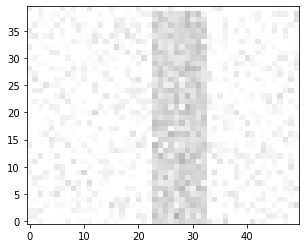

In [354]:
plt.imshow(img,cmap='gray',vmin=0,vmax=1,origin='lower')

In [346]:
def rec_model(X):
    w,h = X.shape
    #img = torch.ones((w,h))
    img = pyro.sample("obs", dist.Normal(1.,0.005).expand([w,h]).to_event(2))
    points,color_intensity = sample_rectangle()
    coords = (torch.diag(torch.tensor(X.shape).float()) @ points).long()
    
    img[...,x[0]:x[1],y[0]:y[1]] = color_intensity
    X = pyro.sample("obs", dist.Normal(img,0.005), obs=img)
    return X

In [355]:
with pyro.plate('vec', 100):
    background = pyro.sample("bg", dist.Normal(1.,0.005).expand([w,h]).to_event(2))
    points,color_intensity = sample_rectangle()
    coords = (torch.diag(torch.tensor(img.shape).float()) @ points).long()

In [359]:
background.shape

torch.Size([100, 40, 50])

In [360]:
coords.shape

torch.Size([100, 2, 2])

In [415]:
background < coords

RuntimeError: The size of tensor a (50) must match the size of tensor b (2) at non-singleton dimension 2

In [363]:
coords

tensor([[[13, 29],
         [11, 19]],

        [[ 4, 15],
         [ 1, 43]],

        [[34, 39],
         [ 7, 13]],

        [[ 4, 26],
         [ 2, 20]],

        [[ 6,  9],
         [33, 36]],

        [[26, 27],
         [14, 26]],

        [[ 4, 25],
         [ 8, 31]],

        [[ 9, 23],
         [25, 35]],

        [[23, 31],
         [ 1, 19]],

        [[14, 34],
         [ 9, 14]],

        [[26, 34],
         [ 5,  9]],

        [[ 7, 33],
         [41, 42]],

        [[ 2,  8],
         [35, 36]],

        [[ 2, 39],
         [13, 43]],

        [[17, 35],
         [ 7, 48]],

        [[28, 34],
         [ 9, 29]],

        [[17, 27],
         [33, 35]],

        [[ 1,  7],
         [36, 44]],

        [[ 1, 29],
         [37, 40]],

        [[ 9, 21],
         [ 8, 26]],

        [[19, 21],
         [37, 48]],

        [[11, 36],
         [11, 39]],

        [[23, 29],
         [ 7, 27]],

        [[10, 27],
         [12, 15]],

        [[21, 25],
         [ 8, 21]],



In [371]:
coords[0,0,0]coords[:,0,1]

In [406]:
background[0][coords[0][0],coords[0][1]]

tensor([1.0034, 1.0000])

In [399]:
background[0,coords[0,0,0]:coords[0,0,1],coords[0,1,0]:coords[0,1,1]]

tensor([[1.0034, 1.0082, 1.0021, 1.0101, 1.0120, 1.0011, 0.9979, 0.9950],
        [0.9978, 0.9986, 1.0039, 0.9958, 1.0009, 0.9960, 0.9957, 1.0092],
        [1.0052, 1.0021, 1.0129, 0.9984, 1.0036, 1.0041, 1.0080, 0.9966],
        [1.0031, 0.9932, 1.0011, 1.0048, 1.0015, 1.0046, 0.9925, 0.9940],
        [1.0000, 0.9976, 1.0082, 0.9906, 0.9945, 0.9966, 1.0053, 0.9967],
        [1.0022, 0.9840, 1.0086, 0.9989, 0.9976, 0.9976, 0.9959, 1.0048],
        [0.9973, 1.0040, 1.0047, 0.9975, 0.9955, 0.9956, 0.9958, 0.9975],
        [0.9967, 0.9934, 0.9923, 0.9989, 0.9947, 1.0051, 1.0010, 0.9917],
        [1.0001, 1.0009, 0.9979, 1.0025, 0.9972, 0.9978, 0.9919, 1.0013],
        [1.0051, 0.9874, 1.0000, 0.9916, 0.9953, 1.0057, 1.0012, 1.0052],
        [0.9947, 0.9929, 1.0012, 1.0044, 0.9927, 1.0032, 0.9956, 1.0048],
        [0.9976, 0.9985, 1.0026, 0.9934, 1.0010, 0.9952, 0.9995, 1.0013],
        [1.0043, 1.0023, 0.9957, 0.9949, 1.0004, 1.0031, 1.0044, 0.9956],
        [1.0038, 0.9843, 0.9905, 1.008

In [345]:
%debug

> <ipython-input-343-640c0ec1a658>(8)rec_model()
      6     x = (w * points[...,0,:]).long()
      7     y = (h * points[...,1,:]).long()
----> 8     img[...,x[0]:x[1],y[0]:y[1]] = color_intensity
      9     X = pyro.sample("obs", dist.Normal(img,0.005), obs=img)
     10     return X

ipdb> img.gather(x)
*** TypeError: gather() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (name dim, Tensor index, bool sparse_grad)
 * (int dim, Tensor index, bool sparse_grad)
ipdb> img.gather(0,x)
*** RuntimeError: invalid argument 4: Index tensor must have same dimensions as input tensor at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:638
ipdb> x
tensor([[35, 36],
        [ 6, 25],
        [28, 37],
        [ 1,  8],
        [ 9, 28],
        [ 6, 13],
        [ 9, 29],
        [ 2, 14],
        [15, 32],
        [ 2, 36],
        [11, 27],
        [26, 32],
        [19, 25],
        [11, 16],
        [11, 18],
        [19, 28],
        [14, 37],
     

ipdb> tmp = torch.diag(torch.tensor(X.shape).float()) @ points
ipdb> tmp.shape
torch.Size([100, 2, 2])
ipdb> tmp[0]
tensor([[35.2407, 36.4273],
        [22.3655, 28.2310]])
ipdb> x[0]
tensor([35, 36])
ipdb> c


In [ ]:
torch.gather()

In [310]:
foo = pyro.poutine.trace(sample_image).get_trace(img)

In [292]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_sample
from pyro.infer import SVI, Trace_ELBO
import pyro.optim

In [293]:
guide = AutoDiagonalNormal(rec_model,init_loc_fn=init_to_sample)

In [294]:
pyro.clear_param_store()
optim = pyro.optim.ClippedAdam({"lr": 0.001})
elbo = Trace_ELBO(num_particles=100, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(rec_model, guide, optim, loss=elbo)

In [295]:
losses = []
for i in range(10000):
    losses.append(svi.step(img))

ValueError: shape mismatch: objects cannot be broadcast to a single shape: torch.Size([2, 2]) vs torch.Size([100, 1])
                  Trace Shapes:            
                   Param Sites:            
         AutoDiagonalNormal.loc         5  
       AutoDiagonalNormal.scale         5  
                  Sample Sites:            
  num_particles_vectorized dist         |  
                          value     100 |  
_AutoDiagonalNormal_latent dist 100   1 | 5
                          value 100   1 | 5

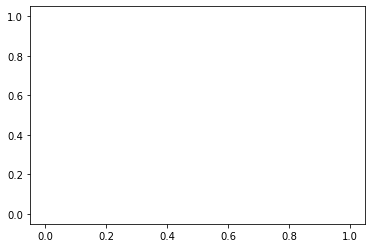

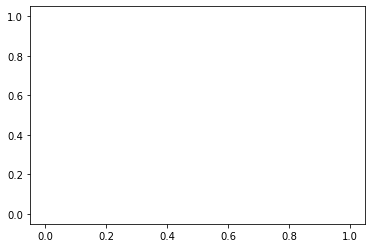

In [296]:
plt.plot(losses)
plt.figure()
plt.plot(losses[:1000])

In [257]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(rec_model),guide=guide,num_samples=100)

In [258]:
fit = pred(img)

In [259]:
fit

{'x': tensor([[[0.9364, 0.5067],
          [0.0539, 0.4271]],
 
         [[0.7131, 0.2621],
          [0.1178, 0.0741]],
 
         [[0.6615, 0.1950],
          [0.7408, 0.6333]],
 
         [[0.8259, 0.7072],
          [0.3637, 0.2637]],
 
         [[0.6424, 0.1530],
          [0.9212, 0.5803]],
 
         [[0.5379, 0.0556],
          [0.2078, 0.1918]],
 
         [[0.8691, 0.3395],
          [0.6975, 0.9442]],
 
         [[0.1283, 0.3793],
          [0.8936, 0.4233]],
 
         [[0.3716, 0.5689],
          [0.6570, 0.2258]],
 
         [[0.9378, 0.8526],
          [0.9449, 0.0196]],
 
         [[0.5047, 0.0428],
          [0.0521, 0.2469]],
 
         [[0.2647, 0.0553],
          [0.7112, 0.1063]],
 
         [[0.4745, 0.1039],
          [0.9865, 0.5382]],
 
         [[0.0316, 0.0138],
          [0.6957, 0.7470]],
 
         [[0.6747, 0.5699],
          [0.7812, 0.6009]],
 
         [[0.9778, 0.2531],
          [0.3591, 0.9557]],
 
         [[0.0138, 0.8061],
          [0.9059, 0.61

In [260]:
fit['obs'].shape

torch.Size([100, 40, 50])

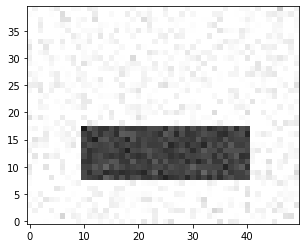

In [261]:
plt.imshow(img,cmap='gray',vmin=0,vmax=1,origin='lower')

In [268]:
fit['obs'].mean(0)

tensor([[1.0021, 0.9891, 0.9927,  ..., 1.0027, 0.9956, 0.9921],
        [0.9912, 0.9906, 0.9854,  ..., 0.9989, 1.0018, 1.0100],
        [0.9897, 0.9877, 0.9803,  ..., 1.0093, 0.9972, 1.0002],
        ...,
        [1.0039, 1.0048, 1.0002,  ..., 0.9917, 1.0016, 1.0032],
        [1.0048, 1.0025, 1.0020,  ..., 0.9850, 1.0010, 1.0035],
        [0.9978, 0.9976, 0.9983,  ..., 0.9924, 0.9955, 0.9958]],
       grad_fn=<MeanBackward1>)

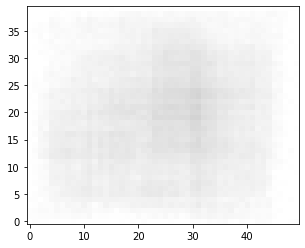

In [269]:
plt.imshow(fit['obs'].mean(0).detach(),cmap='gray',vmin=0,vmax=1,origin='lower')

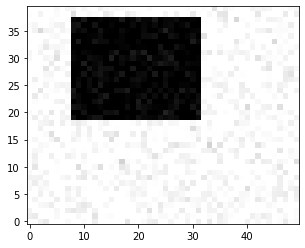

In [267]:
idx = np.random.randint(100)
plt.imshow(fit['obs'][idx].detach(),cmap='gray',vmin=0,vmax=1,origin='lower')